In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantMonitor4Params

In [5]:
from verified_twin.lbuc import *
import sage.all as sg
from sage.all import RIF

In [6]:
sg.var("T_A", "T_H")

(T_A, T_H)

In [7]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

In [8]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

/home/sage/sage/local/lib/python3.9/site-packages/control/xferfcn.py:1498: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(data[i][j][k], (int, np.int)):


In [9]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [10]:
from digital_twin.calibration.uncertainty_calibrator import UncertaintyCalibrator

In [11]:
properties = [
    Atomic(T_H < RIF(60)),
    Atomic(T_A > RIF(21)),
    Atomic(T_A < RIF(46)) & Atomic(T_A > RIF(36)),
]

## Self-Adaptation Loop Integration

In [12]:
config = load_config("startup.conf")

n_samples_period = config["physical_twin"]["controller_open_loop"]["n_samples_period"]
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 10
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 6000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

verified_monitor = VerifiedPlantMonitor4Params(properties)
uncertainty_calibrator = UncertaintyCalibrator(database)

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer,
                                         verified_monitor,
                                         uncertainty_calibrator,
                                         lookahead_time=500.0)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
# Should the supervisor also trigger verified monitoring
supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
                                   trigger_optimization_threshold, heater_underused_threshold,
                                   wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 1000 else (G_box * 10 if m.time() < 2000 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


running verified monitoring for anomaly between times 1002.5938409201124 and 1035.5938409201124




























































ran verified simulation in 19.709047555923462 sec
and mask = None
and sig = None
and mask = None
and sig = None
running verified monitoring for anomaly between times 1068.5938409201124 and 1101.5938409201124

























































ran verified simulation in 19.44847536087036 sec
and mask = None
and sig = None
and mask = None
and sig = None
running verified monitoring for anomaly between times 2013.5938409201124 and 2046.5938409201124






































ran verified simulation in 20.16184711456299 sec
and mask = None
and sig = None
and mask = None
and sig = None
running verified monitoring for anomaly between times 2076.593840920112 and 2109.593840920112




















ran verified simulation in 27.477778434753418 sec
and mask = None
and sig = None
and mask = None
and sig = No

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       5.99459384e+03, 5.99759384e+03, 6.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.994

In [13]:
G(RIF(5,10), Atomic(T_H)).duration

10.0000000000000

In [14]:
m.self_adaptation_manager.state_machine.anomaly_durations

[(1002.5938409201124, 1035.5938409201124),
 (1068.5938409201124, 1101.5938409201124),
 (2013.5938409201124, 2046.5938409201124),
 (2076.593840920112, 2109.593840920112)]

In [15]:
m.supervisor.state_machine.supervisor_trigger_times

[]

In [16]:
m.self_adaptation_manager.state_machine.anomaly_parameters

[(1038.5938409201124,
  1538.5938409201124,
  5.?e1,
  1.2?e2,
  21,
  3.0,
  10,
  5,
  147.?,
  8.?,
  227.76228512,
  1.92343277),
 (1104.5938409201124,
  1604.5938409201124,
  4.?e1,
  93.?,
  21,
  3.0,
  10,
  5,
  137.?,
  8.?,
  227.76228512,
  1.92343277),
 (2049.5938409201126,
  2549.5938409201126,
  4.?e1,
  7.?e1,
  21,
  3.0,
  10,
  0,
  1.5?e2,
  1.?,
  227.76228512,
  1.92343277),
 (2112.593840920112,
  2612.593840920112,
  5.?e1,
  6.?e1,
  21,
  3.0,
  10,
  1,
  1.5?e2,
  0.8?,
  227.76228512,
  1.92343277)]

In [17]:
m.self_adaptation_manager.state_machine.verified_monitoring_results

[[Signal([1038.5938409201123 .. 1538.5938409201124], [([1038.5938409201123 .. 1538.5938409201124], False)], mask=None),
  Signal([1038.5938409201123 .. 1538.5938409201124], [([1038.5938409201123 .. 1538.5938409201124], True)], mask=None),
  Signal([1038.5938409201123 .. 1538.5938409201124], [([1038.5938409201123 .. 1082.6734205267688], True), ([1082.6738409201127 .. 1082.6803327277469], True), ([1131.1138409201132 .. 1538.5938409201124], False)], mask=None)],
 [Signal([1104.5938409201123 .. 1604.5938409201124], [([1104.5938409201123 .. 1604.5938409201124], False)], mask=None),
  Signal([1104.5938409201123 .. 1604.5938409201124], [([1104.5938409201123 .. 1604.5938409201124], True)], mask=None),
  Signal([1104.5938409201123 .. 1604.5938409201124], [([1127.2138409201124 .. 1127.2193958310591], False), ([1127.2238409201124 .. 1127.2326099764212], False), ([1127.2338409201124 .. 1604.5938409201124], False)], mask=None)],
 [Signal([2049.5938409201125 .. 2549.5938409201126], [([2049.593840920

### Manually do some verified simulation for anomolies

#### Anomaly 1

In [18]:
m.self_adaptation_manager.state_machine.anomaly_durations[0]

(1002.5938409201124, 1035.5938409201124)

In [19]:
m.self_adaptation_manager.state_machine.anomaly_parameters[0]

(1038.5938409201124,
 1538.5938409201124,
 5.?e1,
 1.2?e2,
 21,
 3.0,
 10,
 5,
 147.?,
 8.?,
 227.76228512,
 1.92343277)

In [20]:
verified_trace1, verified_model1 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[0])
verified_sigs1 = m.self_adaptation_manager.state_machine.verified_monitoring_results[0]

ran verified simulation in 20.15474557876587 sec


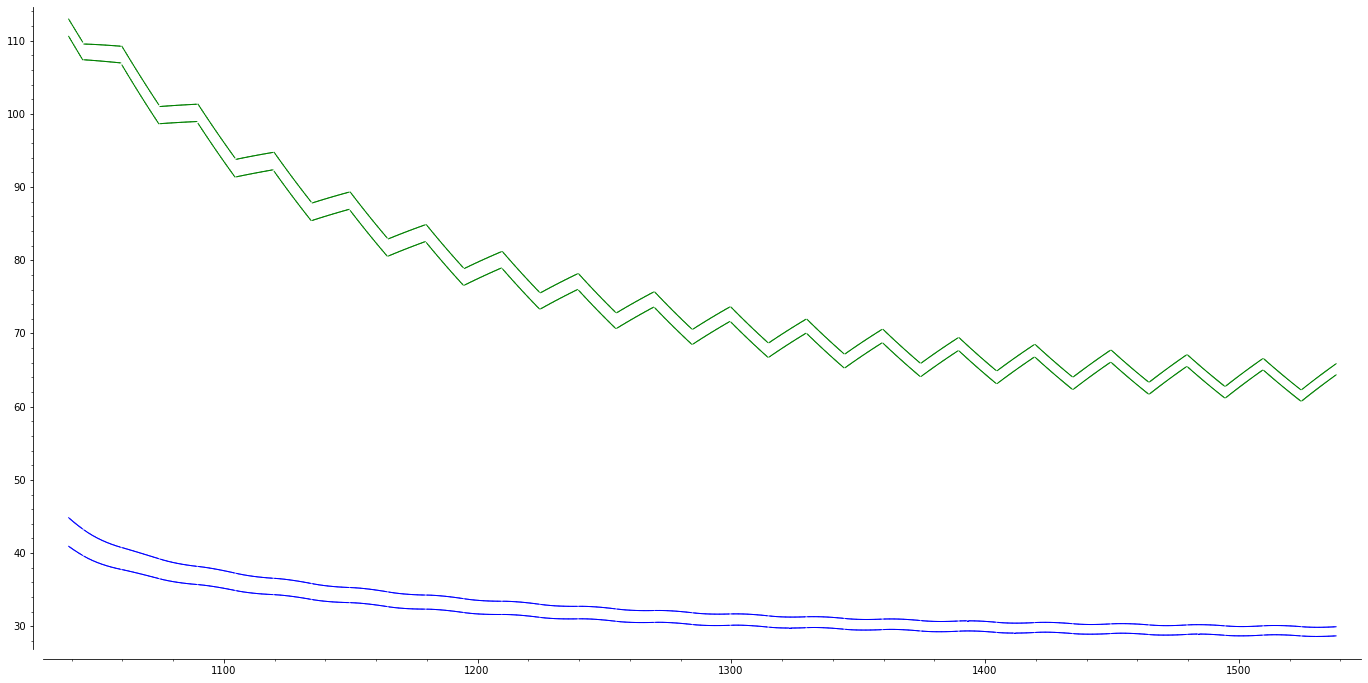

In [21]:
p1 = verified_trace1.plot(('T_A', 'T_H'), color=('blue', 'green')); p1.matplotlib()

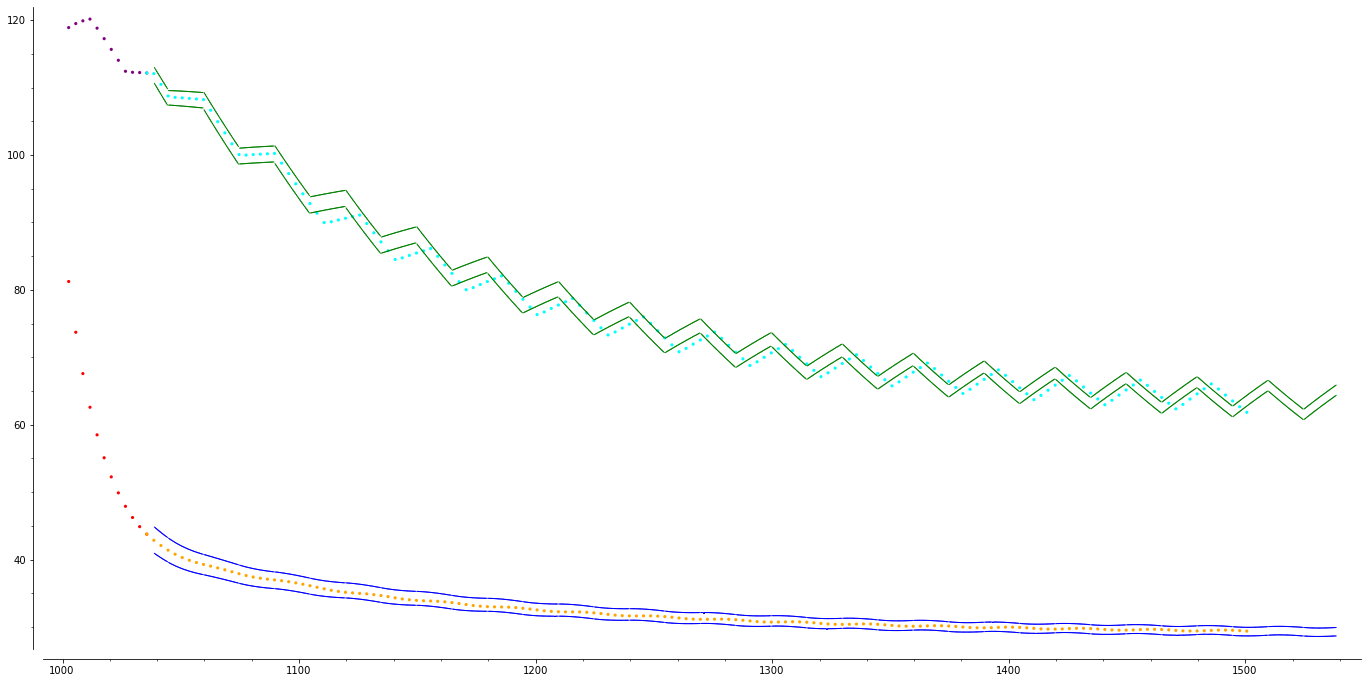

In [22]:
(p1 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[0])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[0][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[0][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[0])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[0][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[0][0] + 500)],
    color='orange',
)
).matplotlib()

/home/sage/sage/local/lib/python3.9/site-packages/sage/plot/contour_plot.py:206: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


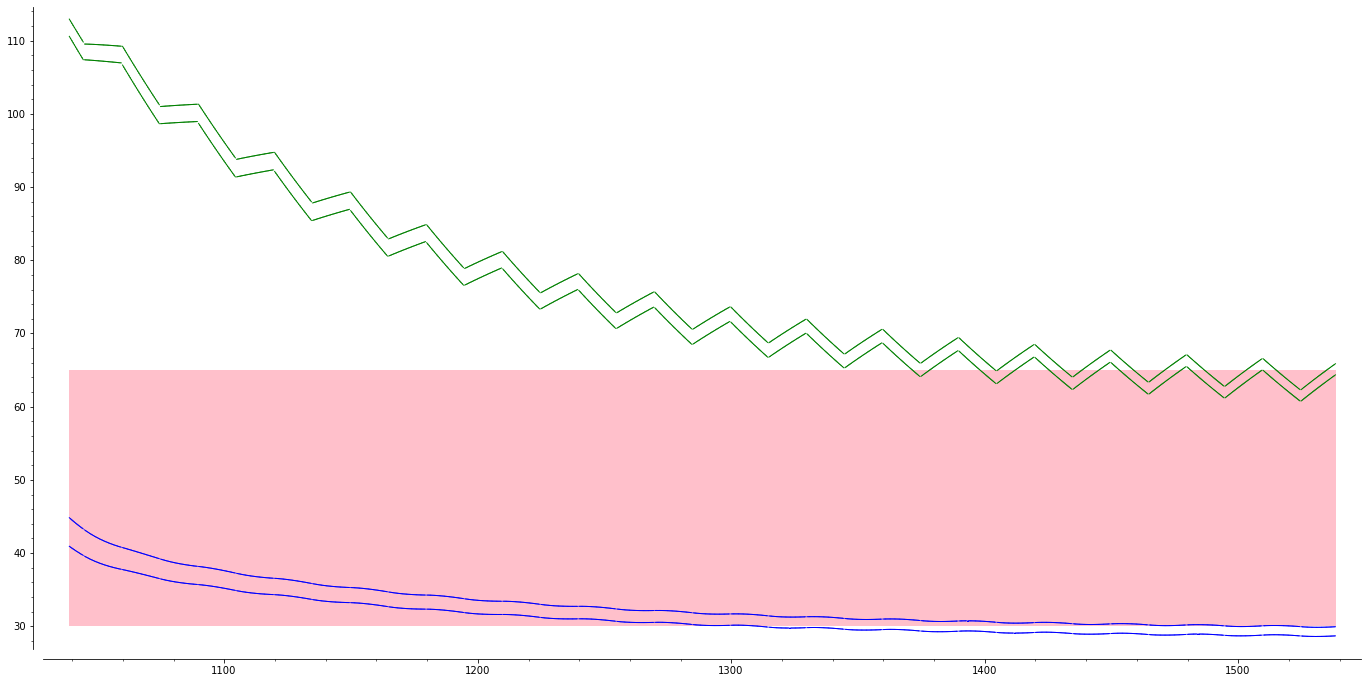

In [23]:
p11 = (verified_sigs1[0].plot(y_range=(30, 65)) + p1)
p11.set_aspect_ratio('auto')
p11.matplotlib()

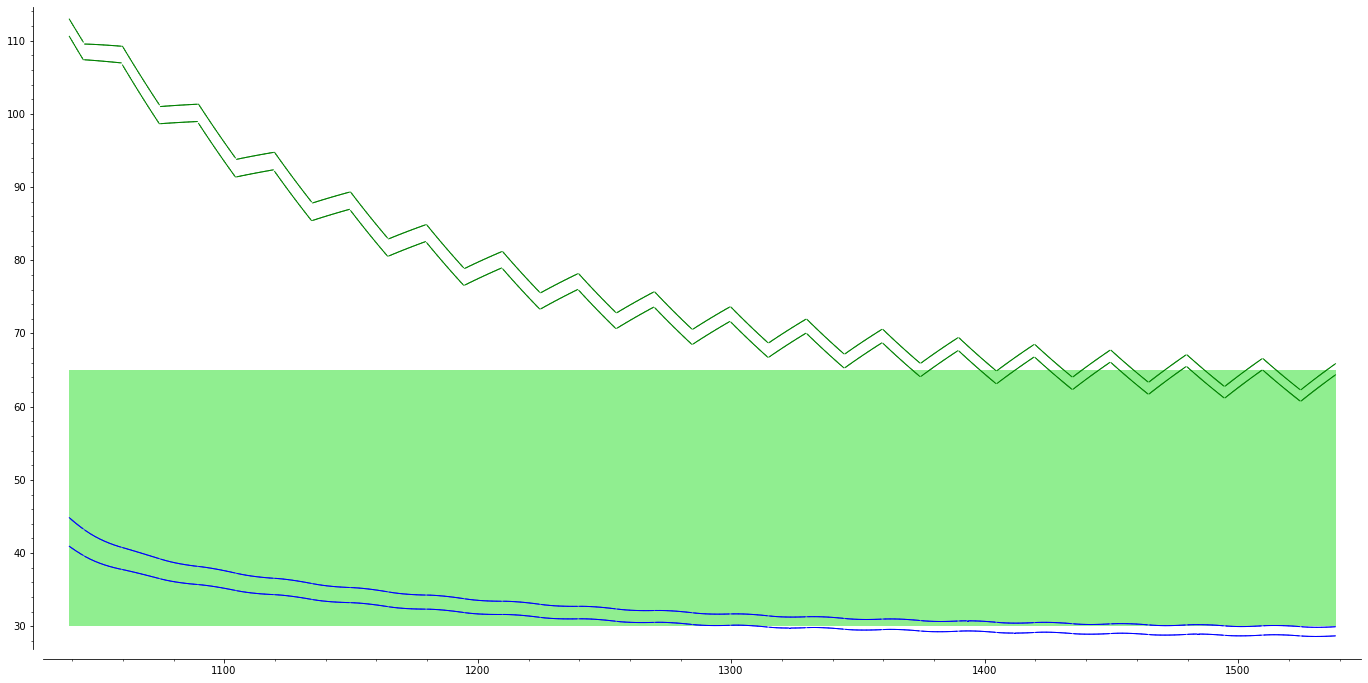

In [24]:
p12 = (verified_sigs1[1].plot(y_range=(30, 65)) + p1)
p12.set_aspect_ratio('auto')
p12.matplotlib()

### Anomoly 2

In [25]:
m.self_adaptation_manager.state_machine.anomaly_parameters[1]

(1104.5938409201124,
 1604.5938409201124,
 4.?e1,
 93.?,
 21,
 3.0,
 10,
 5,
 137.?,
 8.?,
 227.76228512,
 1.92343277)

In [26]:
verified_trace2, verified_model2 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[1])
verified_sigs2 = m.self_adaptation_manager.state_machine.verified_monitoring_results[1]

ran verified simulation in 19.256560802459717 sec


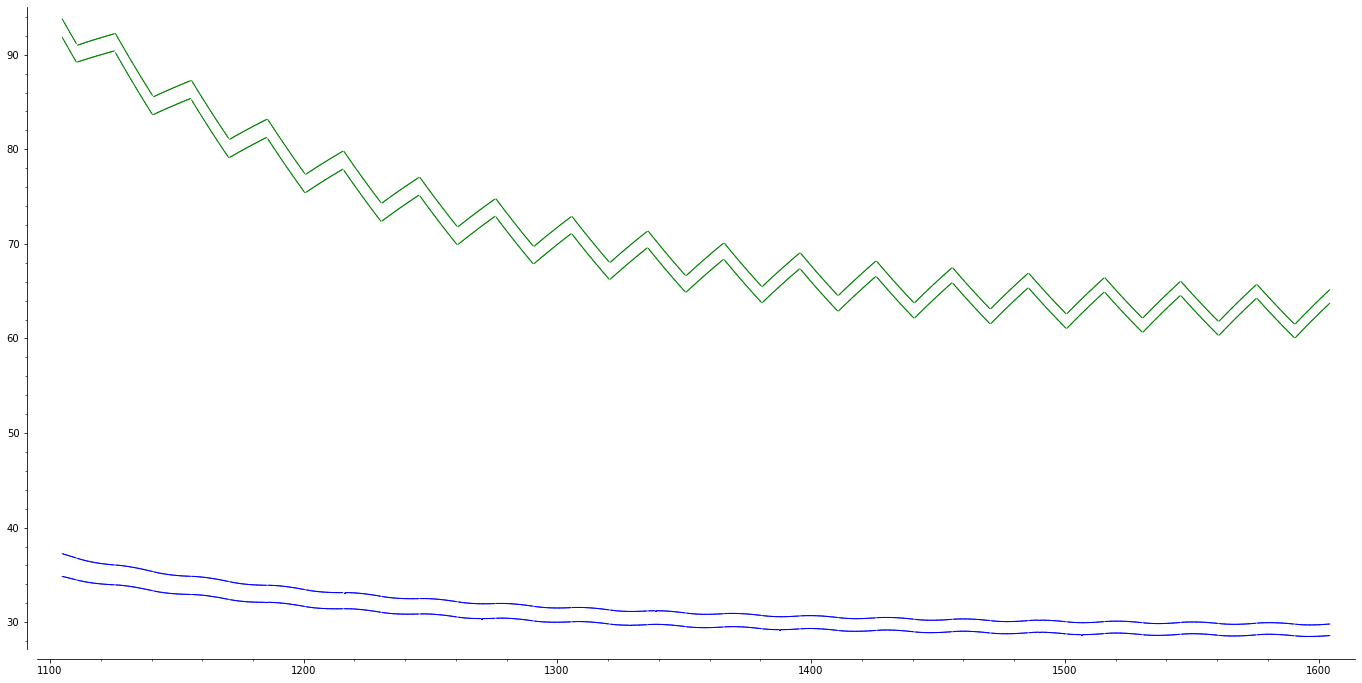

In [27]:
p2 = verified_trace2.plot(('T_A', 'T_H'), color=('blue', 'green')); p2.matplotlib()

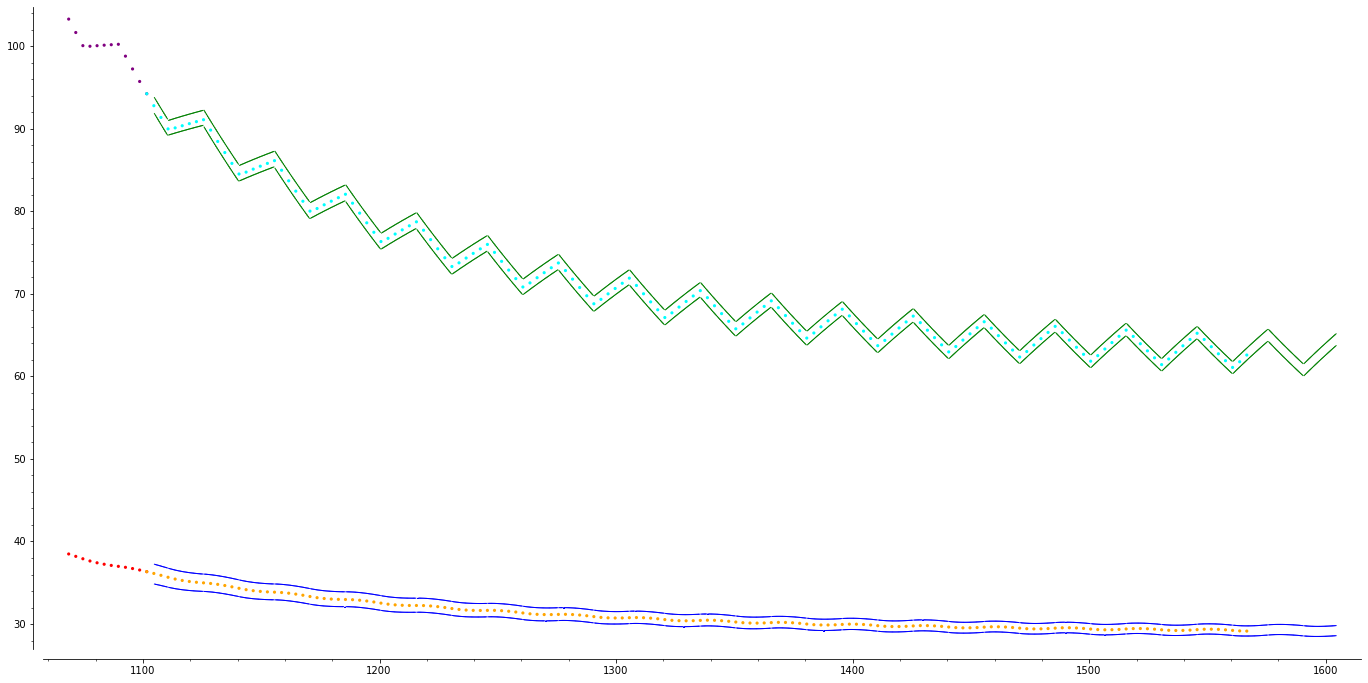

In [28]:
(p2 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[1])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[1][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[1][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[1])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[1][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[1][0] + 500)],
    color='orange',
)
).matplotlib()

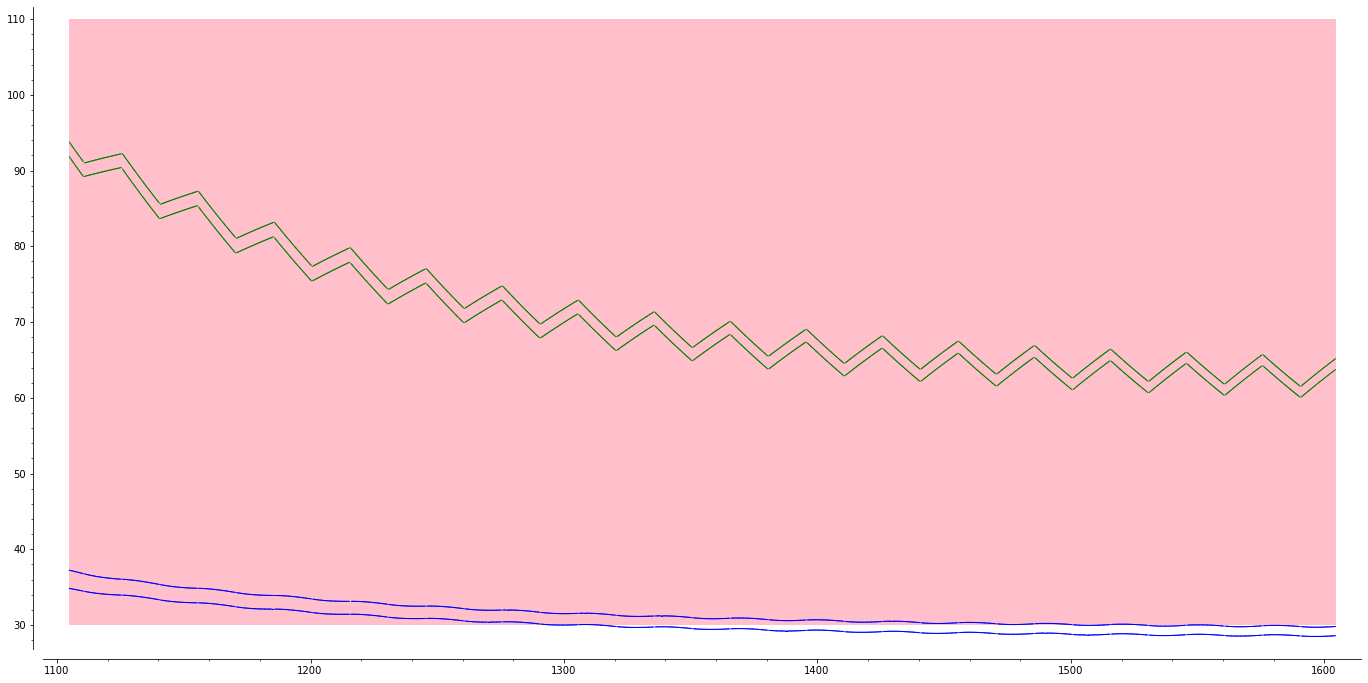

In [29]:
p21 = (verified_sigs2[0].plot(y_range=(30, 110)) + p2)
p21.set_aspect_ratio('auto')
p21.matplotlib()

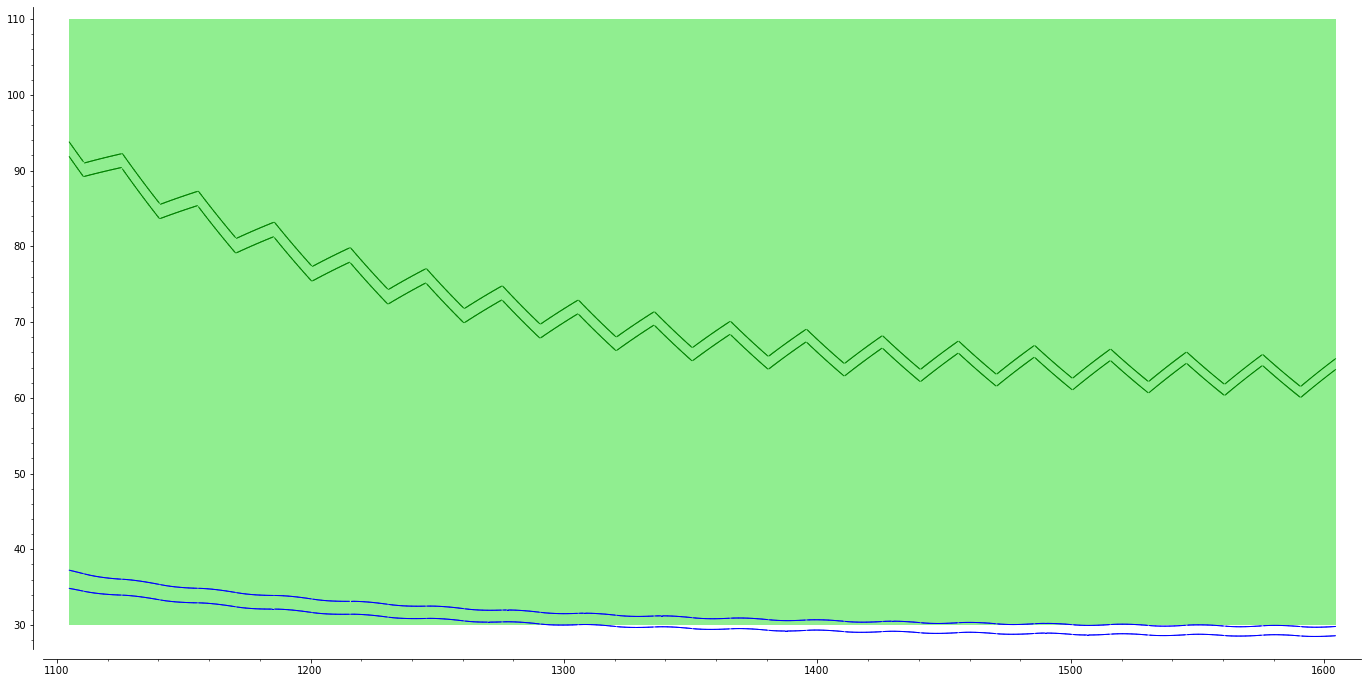

In [30]:
p21 = (verified_sigs2[1].plot(y_range=(30, 110)) + p2)
p21.set_aspect_ratio('auto')
p21.matplotlib()

#### Anomoly 3

In [31]:
m.self_adaptation_manager.state_machine.anomaly_parameters[2]

(2049.5938409201126,
 2549.5938409201126,
 4.?e1,
 7.?e1,
 21,
 3.0,
 10,
 0,
 1.5?e2,
 1.?,
 227.76228512,
 1.92343277)

In [32]:
verified_trace3, verified_model3 = VerifiedPlantMonitor4Params.run_simulation(*m.self_adaptation_manager.state_machine.anomaly_parameters[2])
verified_sigs3 = m.self_adaptation_manager.state_machine.verified_monitoring_results[2]

ran verified simulation in 20.559799671173096 sec


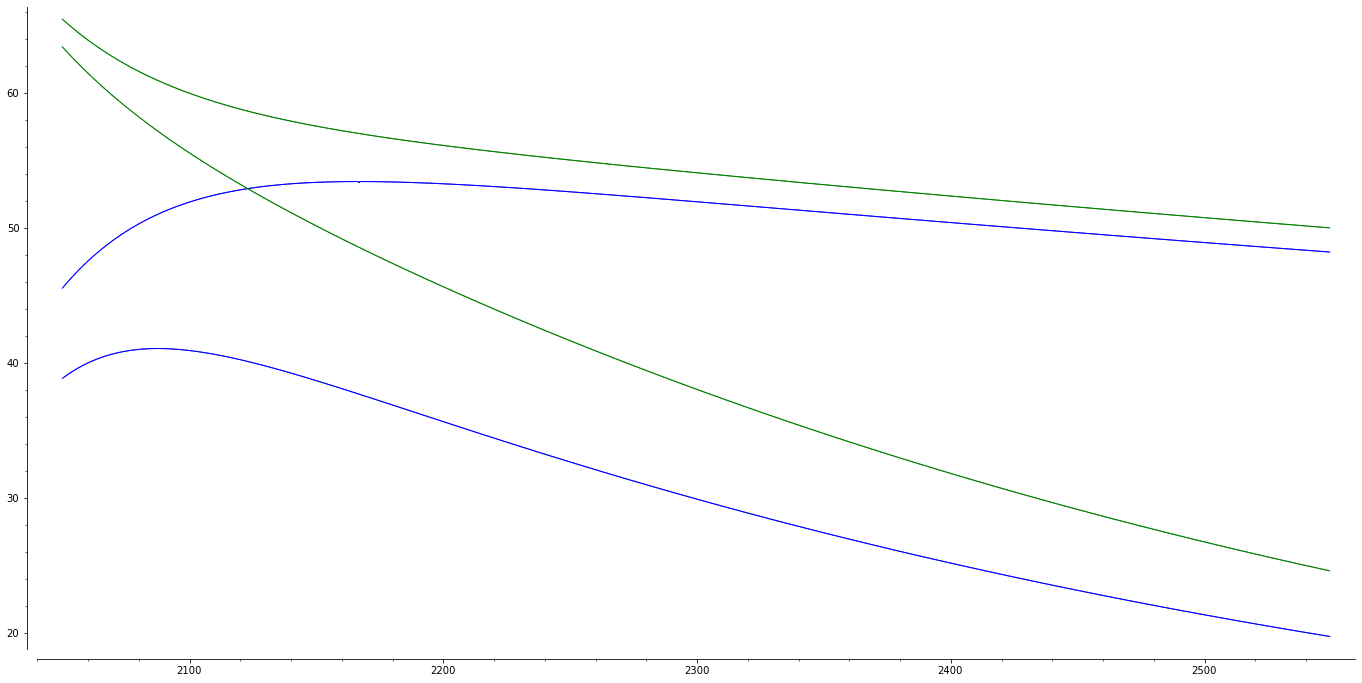

In [33]:
p3 = verified_trace3.plot(('T_A', 'T_H'), color=('blue', 'green')); p3.matplotlib()

In [34]:
m.self_adaptation_manager.state_machine.anomaly_durations[2]

(2013.5938409201124, 2046.5938409201124)

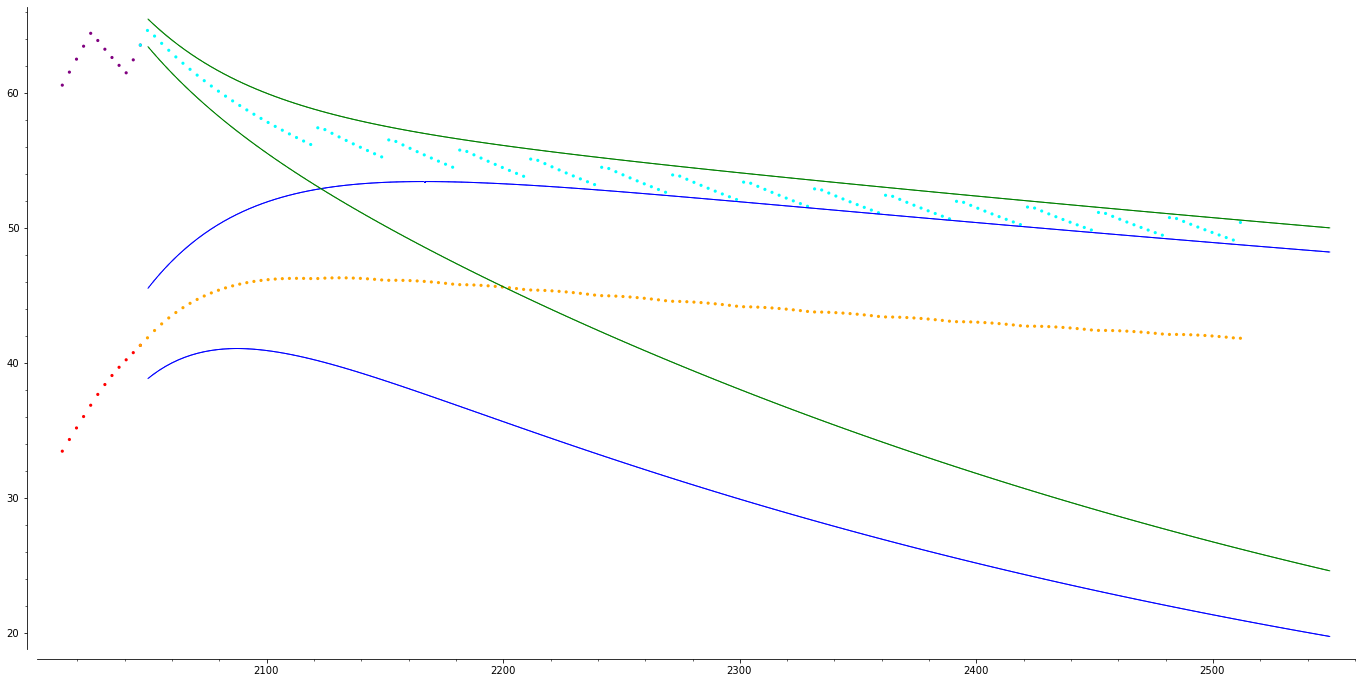

In [35]:
(p3 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[2])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[2][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[2][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[2])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[2][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[2][0] + 500)],
    color='orange',
)
).matplotlib()

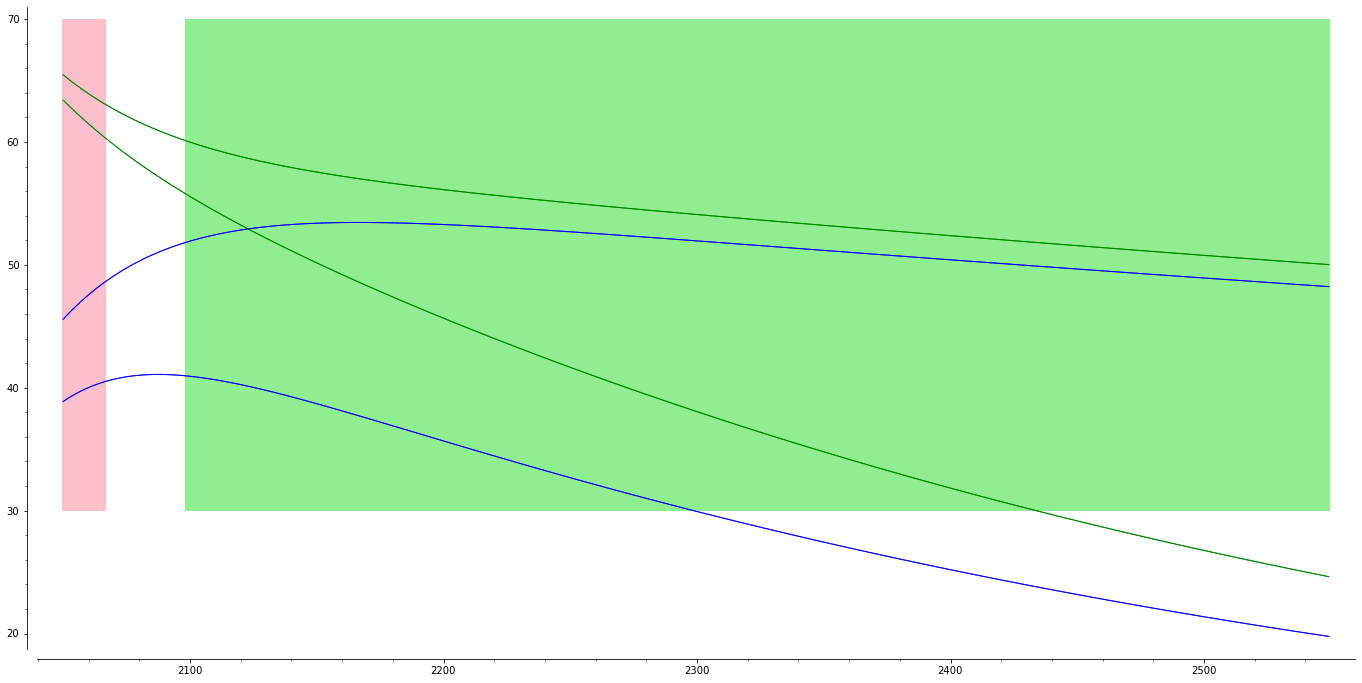

In [36]:
p31 = (verified_sigs3[0].plot(y_range=(30, 70)) + p3)
p31.set_aspect_ratio('auto')
p31.matplotlib()

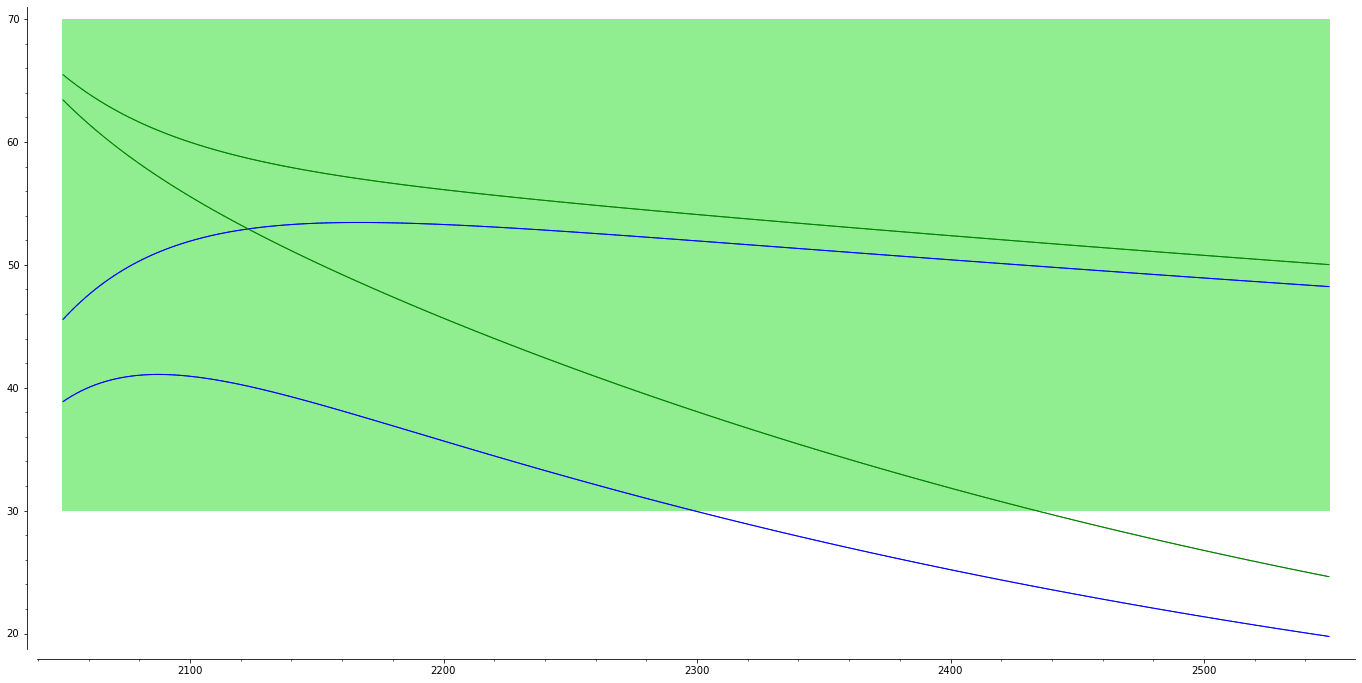

In [37]:
p32 = (verified_sigs3[1].plot(y_range=(30, 70)) + p3)
p32.set_aspect_ratio('auto')
p32.matplotlib()

In [38]:
m.self_adaptation_manager.state_machine.uncertainty_calibration_parameters

[(1002.5938409201124,
  1035.5938409201124,
  146.80090801038583,
  7.940068517942851,
  227.76228512,
  1.92343277),
 (1068.5938409201124,
  1101.5938409201124,
  136.85583104560897,
  7.893908555093671,
  227.76228512,
  1.92343277),
 (2013.5938409201124,
  2046.5938409201124,
  147.42537325341118,
  0.7459200537907551,
  227.76228512,
  1.92343277),
 (2076.593840920112,
  2109.593840920112,
  145.67721692874488,
  0.7915667470569048,
  227.76228512,
  1.92343277)]

In [39]:
m.self_adaptation_manager.state_machine.anomaly_predicted_temperatures

[40.97175112539478,
 40.96878978340622,
 40.997389310191146,
 41.062595796731514,
 41.16548666580619,
 41.30526946128608,
 41.4303112448622,
 41.54401966431516,
 41.64624864241599,
 41.73718022225467,
 41.81716576087568,
 41.9369251464991,
 42.090893418400086,
 42.27731912776096,
 42.49449375510131,
 42.74077015976671,
 42.96452966916392,
 43.17029820699186,
 43.35870392106439,
 43.53037341274181,
 43.685931312105915,
 43.875893029489895,
 44.09489566101729,
 44.3415634888346,
 44.614537314653425,
 44.91247668103896,
 45.18419433742835,
 45.43434339706553,
 45.663624542433155,
 45.872769956679925,
 46.06253538380794,
 46.28358764215821,
 46.53077477638318,
 46.802912052990436,
 47.098806809375525,
 47.41726766356031,
 47.70718257941743,
 47.97331570003442,
 48.216502222832446,
 48.437608215066746,
 48.63751961675221,
 48.867090557484346,
 49.121288215541405,
 49.399016878661904,
 49.699168623646116,
 50.02063324894822,
 50.312330389346926,
 50.5791025887989,
 50.82187520235367,
 51.041

In [40]:
m.self_adaptation_manager.state_machine.anomaly_real_temperatures

[40.89343413361608,
 40.803435217455856,
 40.73871379305887,
 40.734045186209215,
 40.78474185264556,
 40.88646379137607,
 41.03518939641186,
 41.20108342804741,
 41.34601857965197,
 41.471576450635816,
 41.57921916781574,
 41.6703018796663,
 41.77218934661789,
 41.92072006271307,
 42.11219201570815,
 42.34317876715041,
 42.610505557263615,
 42.885122145959244,
 43.12962889392269,
 43.346281920381266,
 43.5371686038274,
 43.70422367247779,
 43.875349128295944,
 44.08688145904817,
 44.33558026323977,
 44.61844698592553,
 44.93270348548921,
 45.249667156857576,
 45.53227912821347,
 45.7831113799731,
 46.00454406357157,
 46.198783277285465,
 46.39398255260561,
 46.626711514608374,
 46.89394584949581,
 47.19288728501423,
 47.520943310998625,
 47.84960337213895,
 48.141968056179365,
 48.4007571320135,
 48.62848772050194,
 48.82749286013707,
 49.026043725607785,
 49.260818966920056,
 49.52889530614443,
 49.8275681011161,
 50.154331606686995,
 50.48075566873323,
 50.77001537700981,
 51.024899

#### Anomoly 4

In [41]:

m.self_adaptation_manager.state_machine.anomaly_parameters[3]

(2112.593840920112,
 2612.593840920112,
 5.?e1,
 6.?e1,
 21,
 3.0,
 10,
 1,
 1.5?e2,
 0.8?,
 227.76228512,
 1.92343277)

In [42]:
params = m.self_adaptation_manager.state_machine.anomaly_parameters[3]

In [43]:
params[0:6]

(2112.593840920112, 2612.593840920112, 5.?e1, 6.?e1, 21, 3.0)

In [44]:
params1 = params[0:6] + (params[7], params[6]) + params[8:]

In [45]:

verified_trace4, verified_model4 = VerifiedPlantMonitor4Params.run_simulation(*params)

ran verified simulation in 21.01648736000061 sec


In [46]:
verified_sigs4 = m.self_adaptation_manager.state_machine.verified_monitoring_results[3]


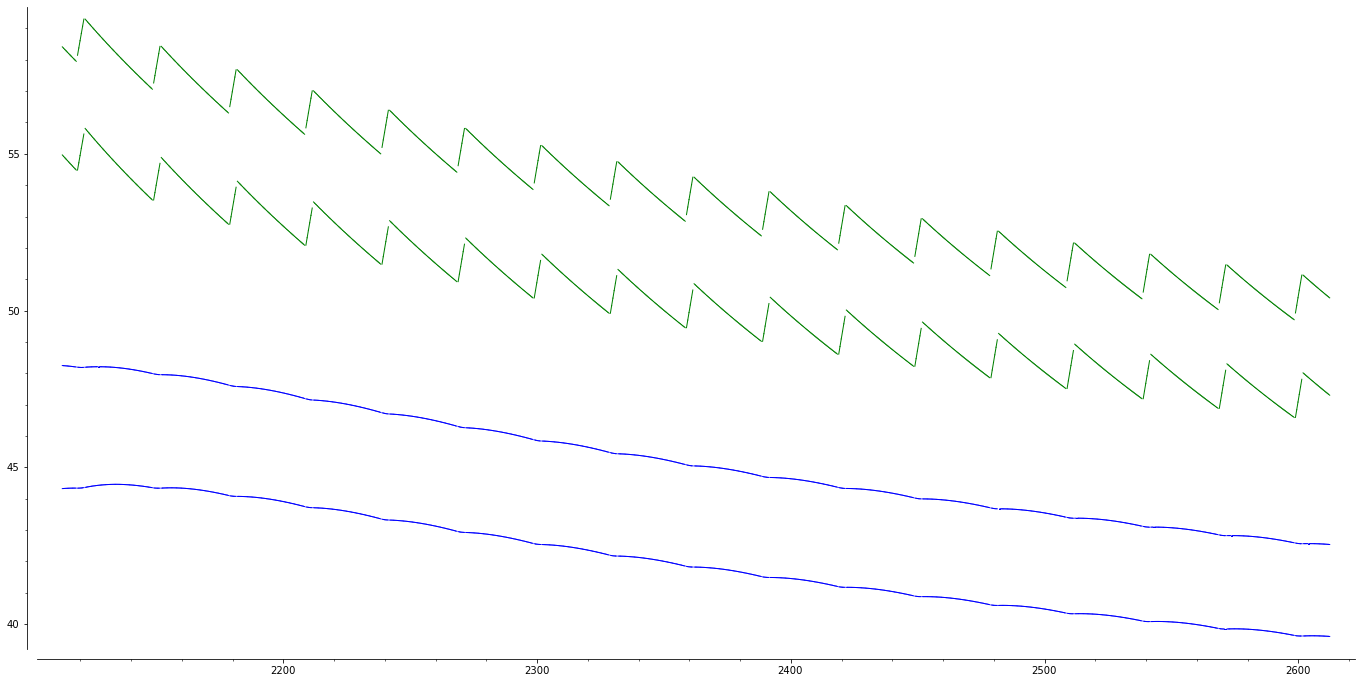

In [47]:
p4 = verified_trace4.plot(('T_A', 'T_H'), color=('blue', 'green')); p4.matplotlib()

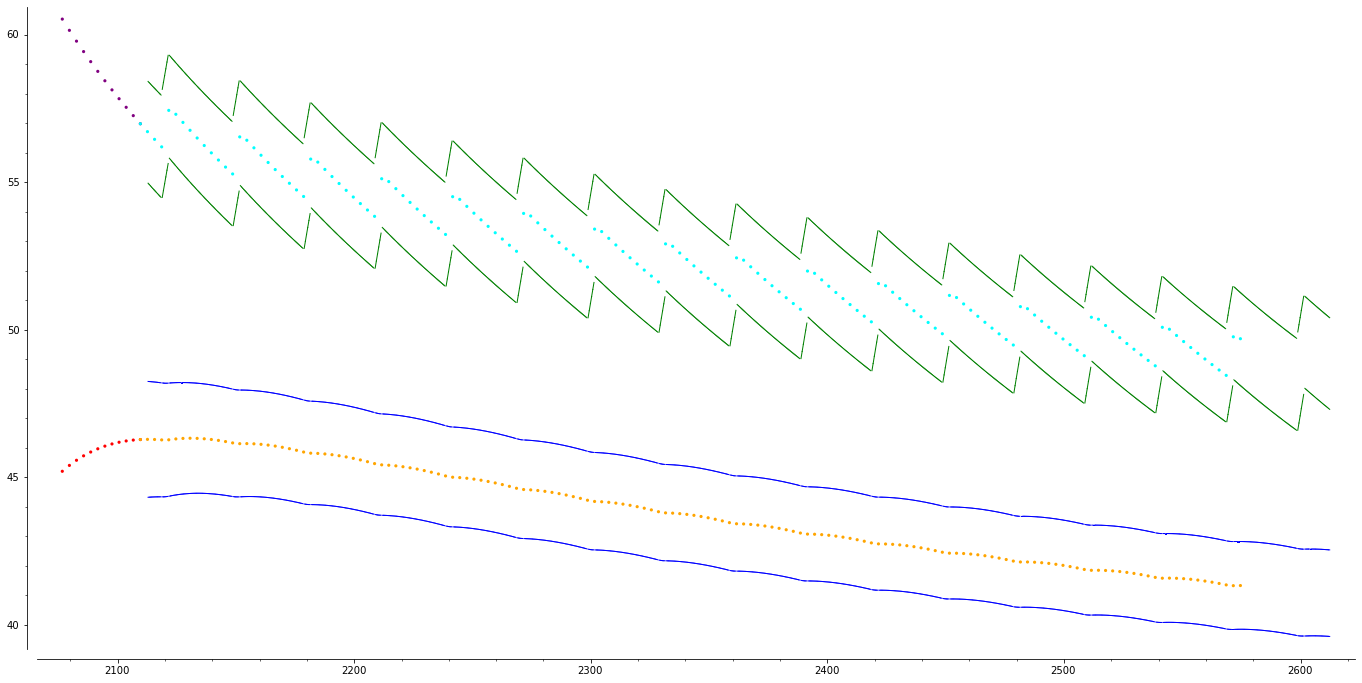

In [48]:

m.self_adaptation_manager.state_machine.anomaly_durations[3]
(p4 + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[3])],
    color='purple',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T_heater'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[3][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[3][0] + 500)],
    color='cyan',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(*m.self_adaptation_manager.state_machine.anomaly_durations[3])],
    color='red',
) + sg.points(
    [(t, T)
     for t, T
     in zip(m.signals['time'], m.physical_twin.plant.signals['T'])
     if t
     in RIF(m.self_adaptation_manager.state_machine.anomaly_durations[3][1],
            m.self_adaptation_manager.state_machine.anomaly_durations[3][0] + 500)],
    color='orange',
)
).matplotlib()

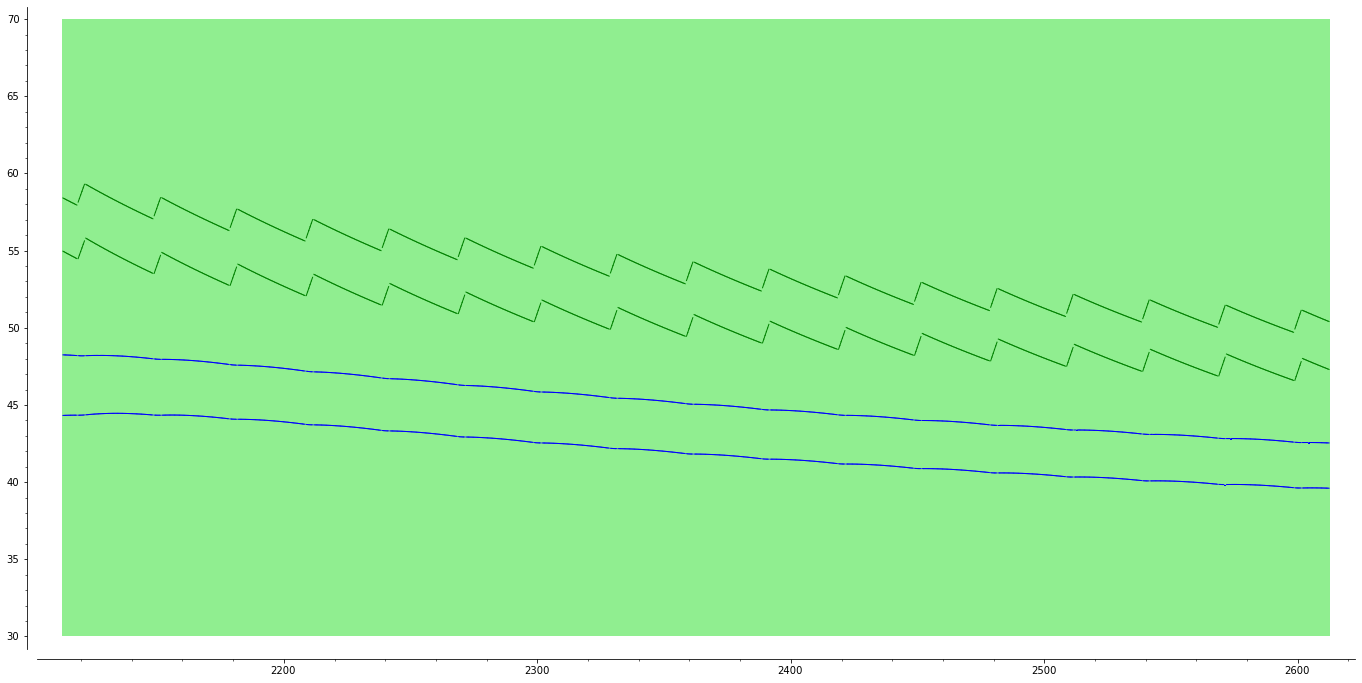

In [49]:

p41 = (verified_sigs4[0].plot(y_range=(30, 70)) + p4)
p41.set_aspect_ratio('auto')
p41.matplotlib()


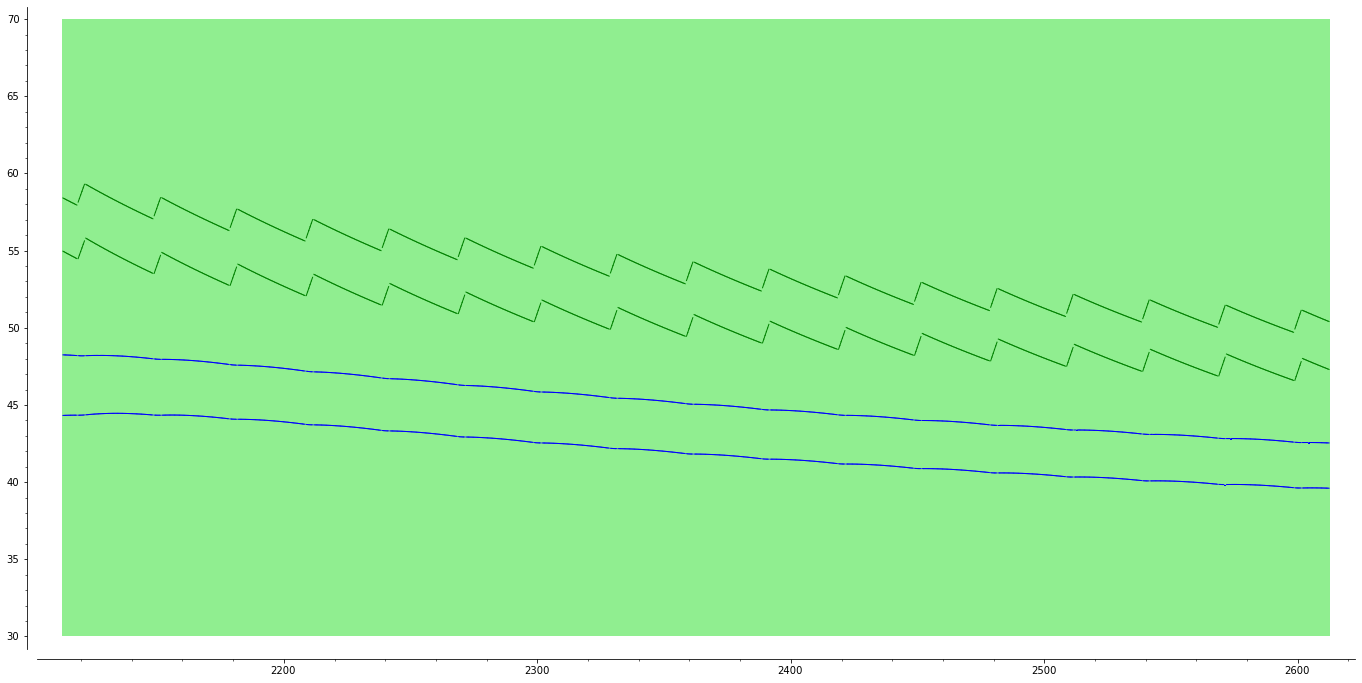

In [50]:
p42 = (verified_sigs4[1].plot(y_range=(30, 70)) + p4)
p42.set_aspect_ratio('auto')
p42.matplotlib()


/home/sage/sage/local/lib/python3.9/site-packages/sage/plot/contour_plot.py:206: UserWarning: No contour levels were found within the data range.
  CS = subplot.contour(self.xy_data_array, contours, cmap=cmap,


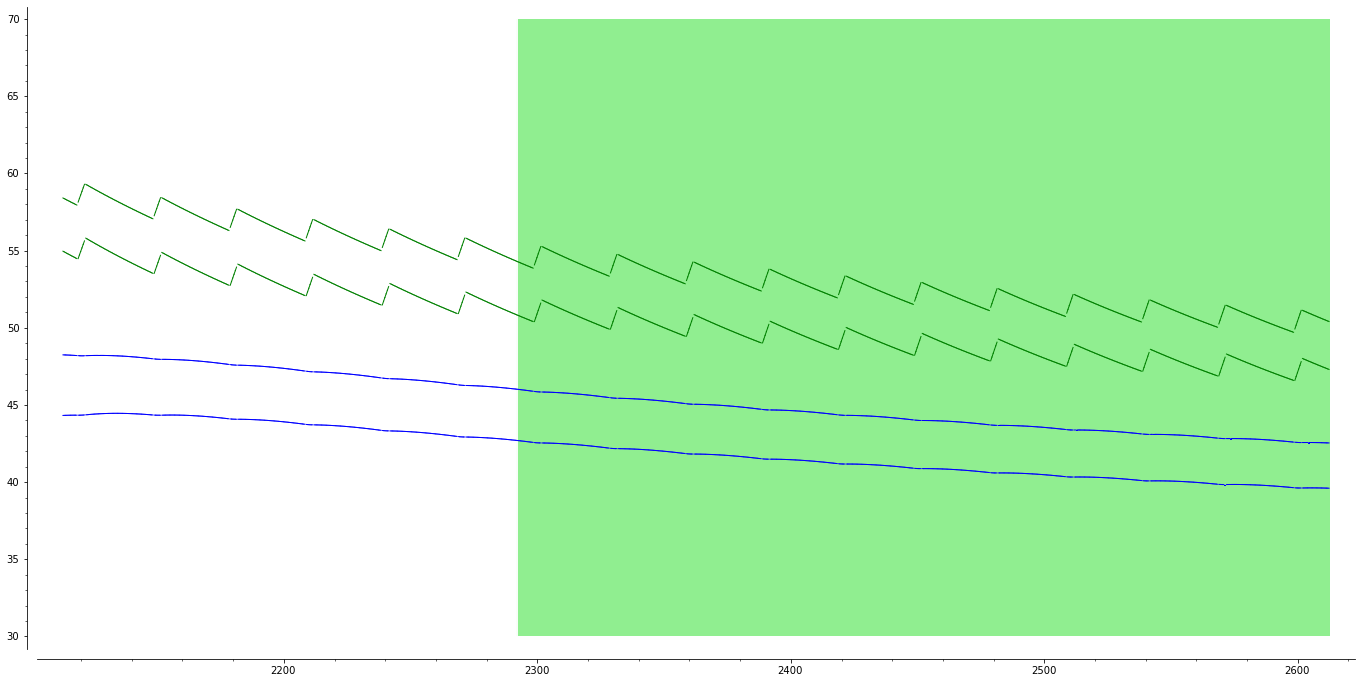

In [54]:
p43 = (verified_sigs4[2].plot(y_range=(30, 70)) + p4)
p43.set_aspect_ratio('auto')
p43.matplotlib()

In [55]:
F(RIF(0, 1000), G(RIF(0, 1000), verified_sigs4[2]))

F([0 .. 1000], G([0 .. 1000], Signal([2112.5938409201121 .. 2612.5938409201122], [([2291.9538409201145 .. 2291.9602215218193], True), ([2291.9638409201147 .. 2612.5938409201122], True)], mask=None)))

In [51]:
m.self_adaptation_manager.state_machine.uncertainty_calibration_parameters
m.self_adaptation_manager.state_machine.anomaly_predicted_temperatures
m.self_adaptation_manager.state_machine.anomaly_real_temperatures

[40.89343413361608,
 40.803435217455856,
 40.73871379305887,
 40.734045186209215,
 40.78474185264556,
 40.88646379137607,
 41.03518939641186,
 41.20108342804741,
 41.34601857965197,
 41.471576450635816,
 41.57921916781574,
 41.6703018796663,
 41.77218934661789,
 41.92072006271307,
 42.11219201570815,
 42.34317876715041,
 42.610505557263615,
 42.885122145959244,
 43.12962889392269,
 43.346281920381266,
 43.5371686038274,
 43.70422367247779,
 43.875349128295944,
 44.08688145904817,
 44.33558026323977,
 44.61844698592553,
 44.93270348548921,
 45.249667156857576,
 45.53227912821347,
 45.7831113799731,
 46.00454406357157,
 46.198783277285465,
 46.39398255260561,
 46.626711514608374,
 46.89394584949581,
 47.19288728501423,
 47.520943310998625,
 47.84960337213895,
 48.141968056179365,
 48.4007571320135,
 48.62848772050194,
 48.82749286013707,
 49.026043725607785,
 49.260818966920056,
 49.52889530614443,
 49.8275681011161,
 50.154331606686995,
 50.48075566873323,
 50.77001537700981,
 51.024899

### Experiment outcome

Parameters:
C_air:  [145.69782402, 146.80090801038583, 136.85583104560897, 147.42537325341118, 145.67721692874488]
G_box:  [0.79154106, 7.940068517942851, 7.893908555093671, 0.7459200537907551, 0.7915667470569048]
C_heater:  [227.76228512, 227.76228512, 227.76228512, 227.76228512, 227.76228512]
G_heater:  [1.92343277, 1.92343277, 1.92343277, 1.92343277, 1.92343277]


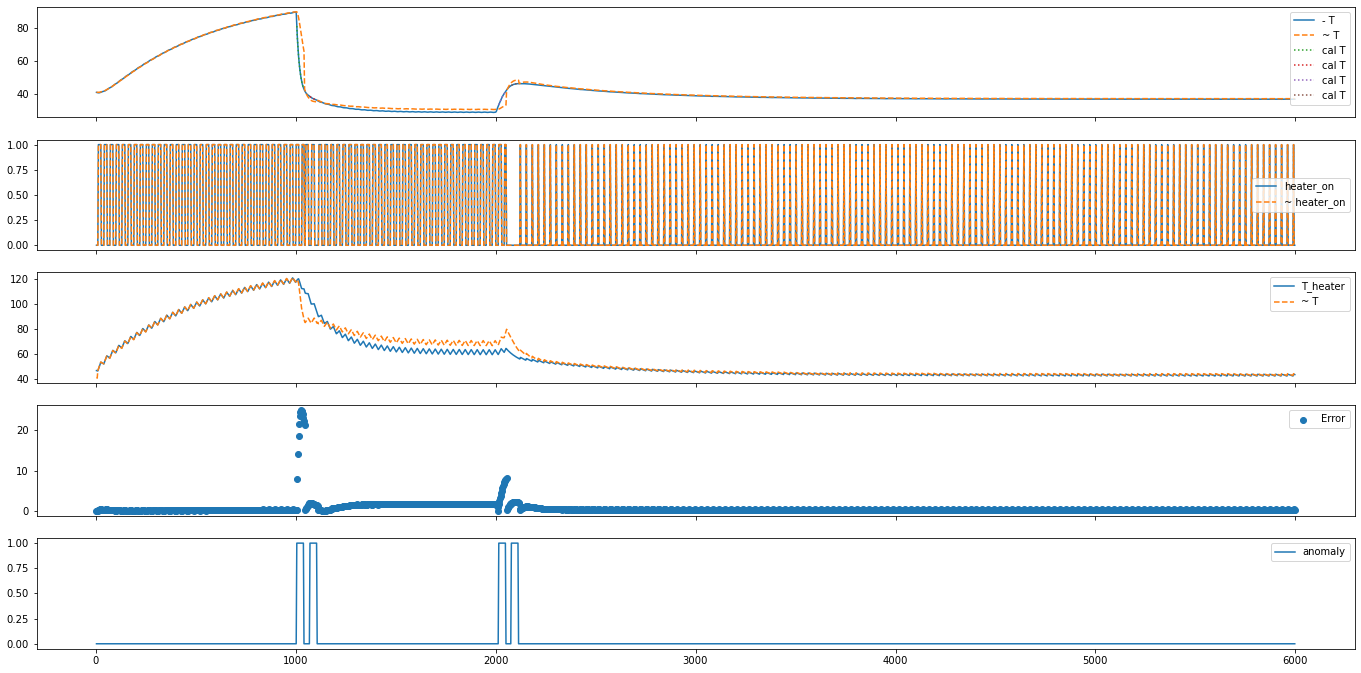

In [52]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex='all')

ax1.plot(m.signals['time'], m.physical_twin.plant.signals['T'], label=f"- T")
ax1.plot(m.signals['time'], m.kalman.signals['out_T'], linestyle="dashed", label=f"~ T")
# ax1.plot(m.signals['time'], m.kalman.signals['out_T_prior'], linestyle="dashed", label=f"~ T_prior")

for (times, trajectory) in database.plant_calibration_trajectory_history:
    ax1.plot(times, trajectory[0, :], label=f"cal T", linestyle='dotted')

#for (times, T, T_heater, heater_on) in database.ctrl_optimal_policy_history:
#    ax1.plot(times, T, label=f"opt T", linestyle='dotted')

ax1.legend()

ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.physical_twin.ctrl.signals['heater_on']], label=f"heater_on")
ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.kalman.signals['in_heater_on']], linestyle="dashed", label=f"~ heater_on")

ax2.legend()

ax3.plot(m.signals['time'], m.physical_twin.plant.signals['T_heater'], label=f"T_heater")
ax3.plot(m.signals['time'], m.kalman.signals['out_T_heater'], linestyle="dashed", label=f"~ T")

ax3.legend()

# The following plot is incorrect, since it does not match with the actual residual computed by the self_adaptation_manager
# ax4.scatter(m.signals['time'],
#             np.absolute(np.array(m.physical_twin.plant.signals['T']) - np.array(m.kalman.signals['out_T'])),
#             label=f"Error")

ax4.scatter(m.signals['time'],
            m.self_adaptation_manager.signals["temperature_residual_abs"],
            label=f"Error")
ax4.legend()

ax5.plot(m.signals['time'],
         [(1
           if any(t in RIF(*p)
                  for p
                  in m.self_adaptation_manager.state_machine.anomaly_durations) 
           else 0)
           for t in m.signals['time']],
         label='anomaly')
ax5.legend()

#ax5.plot(m.signals['time'], m.kalman.signals['out_P_00'], label=f"P_00")
#ax5.plot(m.signals['time'], m.kalman.signals['out_P_11'], label=f"P_11")

#ax5.legend()

#ax6.plot(m.signals['time'], m.kalman.signals['C_air'], label=f"C_air")
#ax6.plot(m.signals['time'], m.kalman.signals['G_box'], label=f"G_box")

#ax6.legend()

print("Parameters:")
print("C_air: ", database.C_air)
print("G_box: ", database.G_box)
print("C_heater: ", database.C_heater)
print("G_heater: ", database.G_heater)
plt.show()

In [53]:
m.supervisor.state_machine.supervisor_trigger_times

[]